In [1]:
from torch import cuda
import splitfolders
import os

In [2]:
cuda.is_available()

True

In [3]:
splitfolders.ratio("dataset", output="train_test_split", seed=1337, ratio=(.9, .0, .1), group_prefix=None)

In [4]:
cwd = os.getcwd()
dataset_path = cwd + "\\train_test_split"
train_path = dataset_path + "\\train"
test_path = dataset_path + "\\test"

In [5]:
import imghdr
import pathlib

for ds in [train_path,test_path]:
  for path in os.listdir(ds):
      filepath = pathlib.Path(str(ds)+'\\'+path)
      for file in os.listdir(filepath):
          currfilepath = str(filepath)+'\\'+file
          if imghdr.what(currfilepath) != 'png':
              print(f'Found broken file! : {file}')
              os.remove(os.path.join(path, currfilepath))

Found broken file! : RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
Found broken file! : Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


In [6]:
import torchvision.transforms as transforms
h = w = 28
channels = 1
batch_size = 64
train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),    
])
test_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
])

C:\Users\darsh\anaconda3\envs\ml\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


In [7]:
import torchvision
from torch.utils.data import DataLoader

In [8]:
tr_data = torchvision.datasets.ImageFolder(root=train_path, transform=train_transform)
tst_data = torchvision.datasets.ImageFolder(root=test_path, transform=train_transform)

In [9]:
train_loader = DataLoader(tr_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(tst_data, batch_size=batch_size, shuffle=False, num_workers=0)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


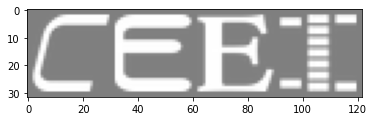

    C     E     E     I


In [101]:
import matplotlib.pyplot as plt
import numpy as np

classes = os.listdir(train_path)
print(classes) # only 10 alphabets
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
import torch
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [107]:
#Dense cnn
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0),
    torch.nn.ReLU(),
    
    torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=0),
    torch.nn.ReLU(),
    
    torch.nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=0),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Flatten(),
    
    torch.nn.Linear(968, 512),
    torch.nn.Linear(512, 128),
    torch.nn.Linear(128, 10), 

    
)

In [108]:
len(classes)

10

In [109]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [112]:
# model.to(device)
for epoch in range(10):
    for data in train_loader:
        image, label = data
#         image = image.to(device)
#         label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
    print(epoch, loss)

0 tensor(0.1446, grad_fn=<NllLossBackward0>)
1 tensor(0.5478, grad_fn=<NllLossBackward0>)
2 tensor(0.1853, grad_fn=<NllLossBackward0>)
3 tensor(0.1136, grad_fn=<NllLossBackward0>)
4 tensor(0.1210, grad_fn=<NllLossBackward0>)
5 tensor(0.1151, grad_fn=<NllLossBackward0>)
6 tensor(0.0953, grad_fn=<NllLossBackward0>)
7 tensor(0.0559, grad_fn=<NllLossBackward0>)
8 tensor(0.3276, grad_fn=<NllLossBackward0>)
9 tensor(0.2136, grad_fn=<NllLossBackward0>)


In [114]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0], data[1]
        outputs = model(images)
        predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted[1] == labels).sum().item()
print("Test accuracy: ", correct / total)

Test accuracy:  0.9287234042553192
